# Feedforward Network with Credit Card Fraud

Let us look at a BigDL example with Credit Card Fraud.  We will train a simple, feedforward neural network with 

In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.models.ml_pipeline.dl_classifier import *
from utils import *

from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


init_engine()

In [2]:
learning_rate = 0.01
training_epochs = 50
batch_size = 1024
display_step = 1

# Network Parameters
n_input = 30
n_classes = 2
n_hidden_1 = 100 # 1st layer number of features
n_hidden_2 = 100 # 2nd layer number of features

LABELS = ["Normal", "Fraud"]

cols = ['Time', 'Amount'] + ["V" + str(x) for x in list(range(1,10))]



In [3]:
cc_training = spark.read.csv("../data/creditcardfraud/creditcard-small.csv.gz", header=True, inferSchema="true", mode="DROPMALFORMED")

In [4]:
df = pd.read_csv("../data/creditcardfraud/creditcard.csv")

In [5]:
cc_training.select('Time', 'V1', 'V2', 'Amount', 'Class').describe().show()

+-------+-----------------+--------------------+-------------------+------------------+-------------------+
|summary|             Time|                  V1|                 V2|            Amount|              Class|
+-------+-----------------+--------------------+-------------------+------------------+-------------------+
|  count|             9061|                9061|               9061|              9061|               9061|
|   mean|93758.12713828495|-0.25424247762411734|0.17199660579747025| 89.94237611742561| 1.0542986425339367|
| stddev|47581.01643785861|  2.7091274040820754|   2.09513286985668|252.94831781126243|0.22661855121864016|
|    min|               35|   -33.0171744306281|  -39.8183101230426|               0.0|                  1|
|    max|           172741|    2.40466311881484|   22.0577289904909|          11898.09|                  2|
+-------+-----------------+--------------------+-------------------+------------------+-------------------+



In [6]:
cc_training = cc_training.select([col(c).cast("double") for c in cc_training.columns])
cc_training = cc_training.withColumn("label", cc_training["Class"])


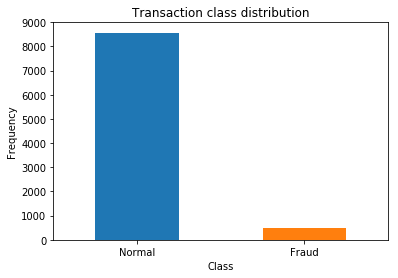

In [7]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('Class').toPandas()['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# get the time to split the data.
splitTime = cc_training.stat.approxQuantile("Time", [0.7], 0.001)[0]

trainingData =cc_training.filter("Time < " + str(splitTime))
validData = cc_training.filter("Time >= " + str(splitTime))

In [9]:
assembler =  VectorAssembler(inputCols=cols, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(trainingData)
data_training = pipelineTraining.transform(trainingData)
pipelineTest = pipeline.fit(validData)
data_test = pipelineTraining.transform(validData)

In [10]:

bigDLModel = Sequential().add(Linear(n_input, 10)).add(Linear(10, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(100).setBatchSize(8)
model = dlClassifier.fit(data_training)
print("\ninitial model training finished.")

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier

initial model training finished.


In [11]:
predictionDF = model.transform(data_test)
predictionDF.cache() 
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + auPRC)
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + recall)

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + precision)  
predictionDF.unpersist()

AttributeError: 'JavaMember' object has no attribute '_get_object_id'

In [ ]:

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0])
plt.title("top1 accuracy")
plt.grid(True)

In [ ]:
predictions = trained_model.predict(cc_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in cc_rdd_test.collect()])

In [ ]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');